# EVALUATION OF LLAMA CHAPTERS

In [1]:
import os 
import pandas as pd
import pickle
import json
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
random.seed(69420)

# Human chapters cleaning

In [3]:
%%time
with open('../data/chapters.pkl', 'rb') as f:
    human_chapters_raw = pickle.load(f)
human_chapters = pd.DataFrame.from_dict(human_chapters_raw, orient='index')
human_chapters = human_chapters[["chapters"]]
human_chapters.reset_index(inplace=True)
human_chapters.rename(columns={'index': 'id'}, inplace=True)
human_chapters.rename(columns={'chapters': 'human'}, inplace=True)
human_chapters.dropna(inplace=True)

CPU times: user 9.28 s, sys: 14.1 s, total: 23.4 s
Wall time: 29.3 s


In [4]:
iteratore = human_chapters["human"]
print(len(iteratore)) 
jason = []

for video in iteratore:
    dict = {}    
    for n, item in enumerate(video):
        title = item["label"]
        dict[f"{n+1}"] = title
    jason.append(dict)
print(len(jason))
    

817076
817076


In [5]:
human_chapters["human_json"] = jason

In [6]:
human_chapters

,id,human,human_json
0,jOiOkFwBpNI,"[{'label': 'You won’t look amazing', 'time': 4...","{'1': 'You won’t look amazing', '2': 'Bad ener..."
1,vBv5G5emgl0,[{'label': 'Sheldon's Financial Situation - Th...,{'1': 'Sheldon's Financial Situation - The Big...
2,IkrXmYjWgIo,"[{'label': 'Introduction', 'time': 0}, {'label...","{'1': 'Introduction', '2': 'Unboxing', '3': 'U..."
3,2rj9fXhUKnI,"[{'label': 'moon sparo - void', 'time': 47}, {...","{'1': 'moon sparo - void', '2': 'moon sparo - ..."
4,C0sdqnGCE2w,"[{'label': 'intro', 'time': 0}, {'label': 'all...","{'1': 'intro', '2': 'allergy shots gone bad', ..."
...,...,...,...
817071,Au6GfZev_kc,[{'label': 'Recording Start - (...after many t...,{'1': 'Recording Start - (...after many techni...
817072,AuTQwyGsMsU,[{'label': '1 Xerox & Freeman - Karina (Remix ...,{'1': '1 Xerox & Freeman - Karina (Remix 1998'...
817073,Auflu6XTrnc,"[{'label': 'Step 1 - Grip', 'time': 136}, {'la...","{'1': 'Step 1 - Grip', '2': 'Step 2- Setup & S..."
817074,AuHNvEwx-4g,"[{'label': 'Intro', 'time': 0}, {'label': 'BTC...","{'1': 'Intro', '2': 'BTC or Fiat pairs explain..."


### The next part, is to collect sentences to feed to the doc2vec model that we wil need to calcualte the cosine similarity

We are sampeling 62000 sentences from all the sentences present in in the human chapters, this is done because we only have 62000 sentences in the in the llama chapters and we want our doc2vec model to be balanced and trained on the same number of humna mande sentences and machine made sentences. We belive that this will make the model more accurate in our particular use case.

In [7]:
tutteFrasiUmani = []
for vid in human_chapters["human_json"]:
    sent = list(vid.values())
    for broccolo in sent:
        tutteFrasiUmani.append(broccolo)

In [8]:
tutteFrasi = random.sample(tutteFrasiUmani, 62000)
len(tutteFrasi)

62000

# LLAMA chapters cleaning

In [9]:
directory = '../data/resLlama'
file_names = []
file_contents = []

for file_name in os.listdir(directory):
    file_path = os.path.join(directory, file_name)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        file_names.append(file_name[:-4])
        file_contents.append(content)

llama_chapters = pd.DataFrame({
    'file_name': file_names,
    'content': file_contents
})
llama_chapters.rename(columns={'file_name': 'id'}, inplace=True)
llama_chapters.rename(columns={'content': 'llama'}, inplace=True)


In [10]:
def clean(sentence):
    index = sentence.find("{")
    return sentence[index:]

def clean2(sentence):
    if sentence.endswith("}"):
        pass
    else:
        sentence = sentence + "\n}"
    return sentence

def clean3(sentence):
    index = sentence.find("}")
    return sentence[:index+1]

llama_chapters["llama_clean"] = llama_chapters["llama"].apply(clean)
llama_chapters["llama_clean2"] = llama_chapters["llama_clean"].apply(clean2)
llama_chapters["llama_clean3"] = llama_chapters["llama_clean2"].apply(clean3)

In [11]:
cosini = llama_chapters["llama_clean3"]
lolol = []

for vidd in cosini:
    try:
        parsed_dict = json.loads(vidd)
        lolol.append(parsed_dict)
    except:
        lolol.append(None) 
    
    

In [12]:
llama_chapters["llama_json"] = lolol

In [13]:
llama_chapters.dropna(inplace=True)

In [14]:
llama_chapters

,id,llama,llama_clean,llama_clean2,llama_clean3,llama_json
0,jKUYFmSn5Eo,"{\n""1"": ""Introduction and Sponsorship"",\n""2"": ...","{\n""1"": ""Introduction and Sponsorship"",\n""2"": ...","{\n""1"": ""Introduction and Sponsorship"",\n""2"": ...","{\n""1"": ""Introduction and Sponsorship"",\n""2"": ...","{'1': 'Introduction and Sponsorship', '2': 'Rh..."
1,da-frvR3iG8,"{\n""1"": ""Introduction to the new Lego Star War...","{\n""1"": ""Introduction to the new Lego Star War...","{\n""1"": ""Introduction to the new Lego Star War...","{\n""1"": ""Introduction to the new Lego Star War...",{'1': 'Introduction to the new Lego Star Wars ...
2,pbzj6mvaHb8,"{\n""1"": ""Introduction to the Audi R8 and its u...","{\n""1"": ""Introduction to the Audi R8 and its u...","{\n""1"": ""Introduction to the Audi R8 and its u...","{\n""1"": ""Introduction to the Audi R8 and its u...",{'1': 'Introduction to the Audi R8 and its uni...
3,RdaVNt-WcWY,"{\n ""1"": ""Jorge Garcia's Post-Lost Life: Fr...","{\n ""1"": ""Jorge Garcia's Post-Lost Life: Fr...","{\n ""1"": ""Jorge Garcia's Post-Lost Life: Fr...","{\n ""1"": ""Jorge Garcia's Post-Lost Life: Fr...",{'1': 'Jorge Garcia's Post-Lost Life: From Fri...
4,BIPUrV4aaFs,"{\n ""1"": ""Introduction and Budget"",\n ""2...","{\n ""1"": ""Introduction and Budget"",\n ""2...","{\n ""1"": ""Introduction and Budget"",\n ""2...","{\n ""1"": ""Introduction and Budget"",\n ""2...","{'1': 'Introduction and Budget', '2': 'Venue a..."
...,...,...,...,...,...,...
8647,mnkw9v5MyNY,"{\n ""1"": ""Morning Routine and Garden Plans""...","{\n ""1"": ""Morning Routine and Garden Plans""...","{\n ""1"": ""Morning Routine and Garden Plans""...","{\n ""1"": ""Morning Routine and Garden Plans""...","{'1': 'Morning Routine and Garden Plans', '2':..."
8648,KnfJUpwF1Gk,"{\n ""1"": ""Morning Routine and Work Prep"",\n...","{\n ""1"": ""Morning Routine and Work Prep"",\n...","{\n ""1"": ""Morning Routine and Work Prep"",\n...","{\n ""1"": ""Morning Routine and Work Prep"",\n...","{'1': 'Morning Routine and Work Prep', '2': 'B..."
8649,tk-VLMdusXo,"{\n""1"": ""Introduction to Cash Flow Maximizatio...","{\n""1"": ""Introduction to Cash Flow Maximizatio...","{\n""1"": ""Introduction to Cash Flow Maximizatio...","{\n""1"": ""Introduction to Cash Flow Maximizatio...",{'1': 'Introduction to Cash Flow Maximization ...
8650,U9doieQXks8,"{\n""1"": ""Welcome Song and Introduction"",\n""2"":...","{\n""1"": ""Welcome Song and Introduction"",\n""2"":...","{\n""1"": ""Welcome Song and Introduction"",\n""2"":...","{\n""1"": ""Welcome Song and Introduction"",\n""2"":...","{'1': 'Welcome Song and Introduction', '2': 'R..."


In [15]:
for vid in llama_chapters["llama_json"]:
    sent = list(vid.values())
    for broccolo in sent:
        tutteFrasi.append(broccolo)

In [16]:
len(tutteFrasi)

125042

# Merge the 2 dataframes

In [17]:
merged_df = pd.merge(llama_chapters, human_chapters, on='id', how='inner')

In [18]:
merged_final = merged_df[["id", "llama_json", "human_json"]]

In [19]:
merged_final

,id,llama_json,human_json
0,jKUYFmSn5Eo,"{'1': 'Introduction and Sponsorship', '2': 'Rh...","{'1': 'Intro', '2': 'Disclaimer', '3': 'Demo S..."
1,da-frvR3iG8,{'1': 'Introduction to the new Lego Star Wars ...,"{'1': 'Outrage', '2': 'Set Overview(s', '3': '..."
2,pbzj6mvaHb8,{'1': 'Introduction to the Audi R8 and its uni...,"{'1': 'Intro', '2': 'Price', '3': 'Exterior De..."
3,RdaVNt-WcWY,{'1': 'Jorge Garcia's Post-Lost Life: From Fri...,"{'1': 'Sticking with J.J. Abrams', '2': 'How H..."
4,BIPUrV4aaFs,"{'1': 'Introduction and Budget', '2': 'Venue a...","{'1': 'Money', '2': 'What I saved money on', '..."
...,...,...,...
8575,mnkw9v5MyNY,"{'1': 'Morning Routine and Garden Plans', '2':...","{'1': 'Starting the garden', '2': 'Dinner time..."
8576,KnfJUpwF1Gk,"{'1': 'Morning Routine and Work Prep', '2': 'B...","{'1': 'Morning Routine', '2': 'On My Way to Wo..."
8577,tk-VLMdusXo,{'1': 'Introduction to Cash Flow Maximization ...,"{'1': 'Why Grow Cash Flow', '2': 'How To GROW ..."
8578,U9doieQXks8,"{'1': 'Welcome Song and Introduction', '2': 'R...","{'1': 'Welcome Song', '2': 'Roly Poly Opposite..."


# Chapter comparison

### Number of chapters

In [20]:
len_data = []
for i in range(len(merged_final["human_json"])):
    llama = merged_final["llama_json"][i]
    human = merged_final["human_json"][i]
    len_diff = np.abs(len(llama) - len(human))
    len_data.append(len_diff)

In [21]:
mean = sum(len_data)/len(len_data)
mean

2.894755244755245

In [22]:
median = np.median(len_data)
median

2.0

In [23]:
stdev = np.std(len_data)
stdev

3.4461214979050445

In [24]:
merged_final.loc[:, "len_diff"] = len_data

/var/folders/j9/w6m91zxs22l58fngjqhl5xm80000gn/T/ipykernel_42077/2542374804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_final.loc[:, "len_diff"] = len_data


In [25]:
merged_final

,id,llama_json,human_json,len_diff
0,jKUYFmSn5Eo,"{'1': 'Introduction and Sponsorship', '2': 'Rh...","{'1': 'Intro', '2': 'Disclaimer', '3': 'Demo S...",1
1,da-frvR3iG8,{'1': 'Introduction to the new Lego Star Wars ...,"{'1': 'Outrage', '2': 'Set Overview(s', '3': '...",0
2,pbzj6mvaHb8,{'1': 'Introduction to the Audi R8 and its uni...,"{'1': 'Intro', '2': 'Price', '3': 'Exterior De...",6
3,RdaVNt-WcWY,{'1': 'Jorge Garcia's Post-Lost Life: From Fri...,"{'1': 'Sticking with J.J. Abrams', '2': 'How H...",1
4,BIPUrV4aaFs,"{'1': 'Introduction and Budget', '2': 'Venue a...","{'1': 'Money', '2': 'What I saved money on', '...",0
...,...,...,...,...
8575,mnkw9v5MyNY,"{'1': 'Morning Routine and Garden Plans', '2':...","{'1': 'Starting the garden', '2': 'Dinner time...",5
8576,KnfJUpwF1Gk,"{'1': 'Morning Routine and Work Prep', '2': 'B...","{'1': 'Morning Routine', '2': 'On My Way to Wo...",0
8577,tk-VLMdusXo,{'1': 'Introduction to Cash Flow Maximization ...,"{'1': 'Why Grow Cash Flow', '2': 'How To GROW ...",5
8578,U9doieQXks8,"{'1': 'Welcome Song and Introduction', '2': 'R...","{'1': 'Welcome Song', '2': 'Roly Poly Opposite...",0


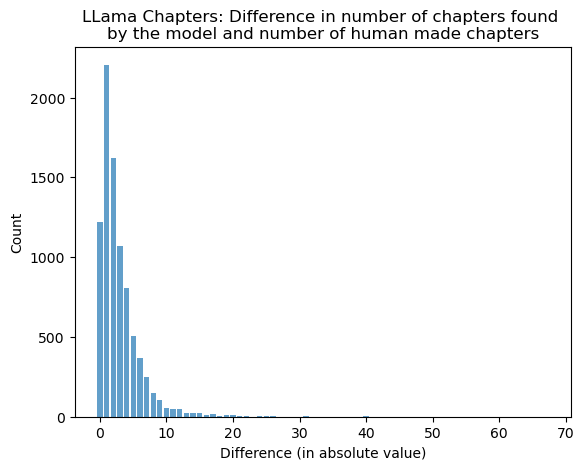

In [26]:
import matplotlib.pyplot as plt

lens = merged_final['len_diff']
value_counts = lens.value_counts().sort_index()

plt.bar(value_counts.index, value_counts.values, alpha=0.7)
plt.xlabel('Difference (in absolute value)')
plt.ylabel('Count')
plt.title('LLama Chapters: Difference in number of chapters found \nby the model and number of human made chapters')
#plt.show()
plt.savefig("resScore/LLama chapters distribution.png", dpi = 400)

## Traning doc2vec model

### Traning the model takes about 1 minute, if you dont want to train it you can simply load it from here:

In [29]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

model_file_path = "doc2vec/Llama/doc2vec_modelLlama"

# Load the saved Doc2Vec model
model = Doc2Vec.load(model_file_path)

If you load the model please use this to check that it was loaded successfully

In [30]:
if isinstance(model, Doc2Vec):
    print("Model loaded successfully.")

    # Check if the vocabulary is loaded
    if len(model.wv) > 0:
        print("Model vocabulary loaded successfully.")
    else:
        print("Model vocabulary is empty.")
else:
    print("Loaded model is not a Doc2Vec instance.")

Model loaded successfully.
Model vocabulary loaded successfully.


### Train doc2vec model

In [27]:
%%time
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_data = [TaggedDocument(words=s.split(), tags=[str(i)]) for i, s in enumerate(tutteFrasi)]

vector_size = 100
window_size = 5
min_count = 1
epochs = 20

model = Doc2Vec(vector_size=vector_size, window=window_size, min_count=min_count, epochs=epochs)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 58.3 s, sys: 13 s, total: 1min 11s
Wall time: 56.8 s


In [28]:
# Define the file path where you want to save the trained model
model_file_path = "doc2vec/Llama/doc2vec_modelLlama"

# Save the trained Doc2Vec model
model.save(model_file_path)

## Cosine Similarity Score

In [92]:
from itertools import combinations_with_replacement

def insert_empties_between(lst, x):
    n = len(lst)
    
    # Generate all ways to distribute x zeros in n+1 positions
    distributions = combinations_with_replacement(range(n+1), x)
    
    results = []
    for distribution in distributions:
        result = []
        elements_iter = iter(lst)
        for pos in range(n):
            for el in distribution:
                if el == pos:
                    result.append('')
            result.append(next(elements_iter))
        for el in distribution:
            if el == n:
                result.append('')
        results.append(result)
            
    return results

In [93]:
def compute_similarity_gen(x, y, verbose = False):
    '''
    x = list of chapters, human
    y = list of chapters, llama
    '''
    def compute_similarity(x, y, min_len):
        
#        print(x)
#        print(y)
        pair_scores = []
        for human_sent, llama_sent in zip(x, y):
            
            # Generate embeddings for sentences
#            print(human_sent.split())
#            print(llama_sent.split())
            human_emb = model.infer_vector(human_sent.split())
            llama_emb = model.infer_vector(llama_sent.split())
#            print(human_emb)
#            print(llama_emb)
        
            # Compute cosine similarity between sentence embeddings
            similarity_score = cosine_similarity([human_emb], [llama_emb])[0][0]
            pair_scores.append(similarity_score)
#            print(pair_scores)
        overall_video_score = sum(pair_scores)/min_len
        return overall_video_score
    
    if len(x) == len(y):
        min_len = len(x)
        return compute_similarity(x,y,min_len)
    if len(x) < len(y):
        min_len = len(x)
        diff = len(y) - len(x)
        similarity = 0
        elem = None
        for el in insert_empties_between(x, diff):
            if compute_similarity(el,y, min_len) > similarity:
                similarity = compute_similarity(el,y, min_len)
                elem = el
        if verbose == True:
            print(similarity, elem, y)
    if len(x) > len(y):
        min_len = len(y)
        diff = len(x) - len(y)
        similarity = 0
        elem = None
        for el in insert_empties_between(y, diff):
            if compute_similarity(x, el, min_len) > similarity:
                similarity = compute_similarity(x, el, min_len)
                elem = el
        if verbose == True:
            print(similarity, x, elem)
        
    return similarity

### Since the calculation of the cosine similarity takes a long time, we saved the "cosine_df" to a csv (LLAMA.csv) and later there is an option to load it back in to check out the cosine similarities

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

llama_json = merged_final["llama_json"]
human_json = merged_final["human_json"]
diff = merged_final['len_diff'].apply(np.abs)

indeces = list(llama_json.index)

all_scores = []

for pointer in tqdm(indeces):
    if diff[pointer] <= 4:
        human_d = human_json[pointer]
        llama_d = llama_json[pointer]
        human_chap_list = list(human_d.values())
        llama_chap_list = list(llama_d.values())

        # Compute embeddings and cosine similarity for each pair of sentences
        all_scores.append(compute_similarity_gen(human_chap_list, llama_chap_list))

100%|██████████| 8580/8580 [46:54<00:00,  3.05it/s]  


In [104]:
np.mean(all_scores)

0.34711819863848253

In [114]:
np.median(all_scores)

0.3403965594867865

In [106]:
cosine_df = merged_final[merged_final["len_diff"] <= 4]
cosine_df.loc[:, "cosine similarity"] = all_scores

/var/folders/j9/w6m91zxs22l58fngjqhl5xm80000gn/T/ipykernel_5237/278484341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosine_df.loc[:, "cosine similarity"] = all_scores


In [107]:
cosine_df

,id,llama_json,human_json,len_diff,cosine similarity
0,jKUYFmSn5Eo,"{'1': 'Introduction and Sponsorship', '2': 'Rh...","{'1': 'Intro', '2': 'Disclaimer', '3': 'Demo S...",1,0.509625
1,da-frvR3iG8,{'1': 'Introduction to the new Lego Star Wars ...,"{'1': 'Outrage', '2': 'Set Overview(s', '3': '...",0,0.244124
3,RdaVNt-WcWY,{'1': 'Jorge Garcia's Post-Lost Life: From Fri...,"{'1': 'Sticking with J.J. Abrams', '2': 'How H...",1,0.359560
4,BIPUrV4aaFs,"{'1': 'Introduction and Budget', '2': 'Venue a...","{'1': 'Money', '2': 'What I saved money on', '...",0,0.302777
5,8_NhdSZQoxE,"{'1': 'Introduction to Clubhouse', '2': 'What ...","{'1': 'Intro', '2': 'What', '3': 'Game-changer...",1,0.580757
...,...,...,...,...,...
8573,TCn2GeeVlg4,{'1': 'Introduction to L-Pod Academy and the I...,"{'1': 'Hand Controls - Steering Wheel', '2': '...",4,0.233142
8574,HkH3nEmD9_8,"{'1': 'Introduction to Role Dividers', '2': 'S...",{'1': 'Updated version for new UI at top of de...,1,0.376767
8576,KnfJUpwF1Gk,"{'1': 'Morning Routine and Work Prep', '2': 'B...","{'1': 'Morning Routine', '2': 'On My Way to Wo...",0,0.271048
8578,U9doieQXks8,"{'1': 'Welcome Song and Introduction', '2': 'R...","{'1': 'Welcome Song', '2': 'Roly Poly Opposite...",0,0.508475


In [108]:
cosine_df.to_csv("resScore/LLAMA.csv")

## Here is the cell to load back in the cosine similarities

In [31]:
cosine_df = pd.read_csv("resScore/LLAMA.csv")

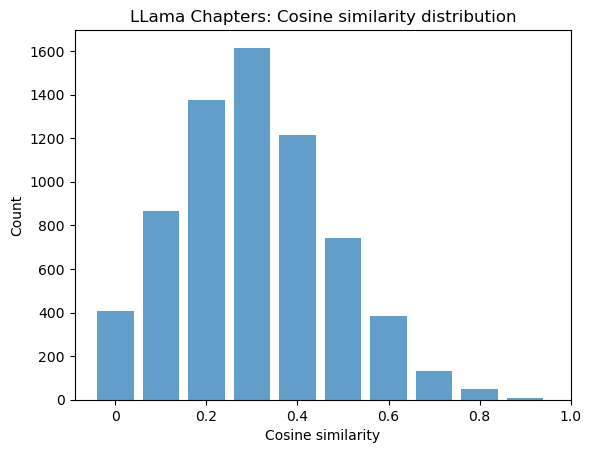

In [33]:
lens = cosine_df["cosine similarity"]

# Define the bins
bins = np.arange(0, 1.1, 0.1)  # Create bins from 0 to 1 with a width of 0.1

# Bin the data
binned_data = pd.cut(lens, bins=bins, include_lowest=True)

# Count the values in each bin
value_counts = binned_data.value_counts().sort_index()

# Plot the binned data
plt.bar(value_counts.index.astype(str), value_counts.values, alpha=0.7)

# Define the custom x-axis labels
x_labels = ['[0.0, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', 
            '(0.5, 0.6]', '(0.6, 0.7]', '(0.7, 0.8]', '(0.8, 0.9]', '(0.9, 1.0]']
x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Get the actual positions of these labels in the bins
bin_positions = [0, 2, 4, 6, 8, 10]  # Adjust these positions if necessary

plt.xticks(bin_positions, x_ticks)

plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('LLama Chapters: Cosine similarity distribution')

# Save the plot
plt.savefig("resScore/LLama chapters cosine.png", dpi=400)
